# Linear regressions on spiracle data with non-parametric confidence intervals for slopes

To begin with, we need to import necessary python packages.

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api
import scipy.stats

import bokeh.io
import bokeh.plotting

from Bio import Phylo
import io

import cmdstanpy
import arviz as az

import bebi103

bokeh.io.output_notebook()

Loading BokehJS ...

We can now read in the data into a dataframe for analyis.

In [2]:
df = pd.read_csv("./20190322_supp_table_2.csv")

We take a look at the format for the data.

In [3]:
df['species_underscore'] = [spec.replace(" ", "_") for  spec in df['species']]
df.head()

subfamily                 species sex  mass (g) spiracle  area (mm^2)  \
0  Cetoniinae     Goliathus goliathus   M    16.280        6     0.274408   
1  Cetoniinae     Goliathus goliathus   F    18.150        6     0.134949   
2  Cetoniinae   Coelorrhina hornimani   M     1.130        6     0.212131   
3  Cetoniinae  Dicronorrhina derbyana   M     2.120        6     0.039532   
4  Cetoniinae  Dicronorrhina derbyana   F     2.145        6     0.049701   

   depth (mm)      species_underscore  
0    2.512648     Goliathus_goliathus  
1    1.606189     Goliathus_goliathus  
2    0.553833   Coelorrhina_hornimani  
3    0.473369  Dicronorrhina_derbyana  
4    0.496320  Dicronorrhina_derbyana

For some of this analysis, we will look at the per-species averages for our measurements. To get this, we use a simple aggregate function on the dataframe and take a look at the results.

In [4]:
df_averages = df.groupby(['species', 'species_underscore', 'spiracle'], as_index=False).aggregate(np.average)
df_averages['subfamily'] = df.groupby(['species', 'species_underscore', 'spiracle'], as_index=False).aggregate(max)['subfamily']
df_averages.head()

species     species_underscore spiracle  area (mm^2)  \
0  Coelorrhina hornimani  Coelorrhina_hornimani        1     0.135347   
1  Coelorrhina hornimani  Coelorrhina_hornimani        2     0.084207   
2  Coelorrhina hornimani  Coelorrhina_hornimani        3     0.106693   
3  Coelorrhina hornimani  Coelorrhina_hornimani        4     0.115574   
4  Coelorrhina hornimani  Coelorrhina_hornimani        5     0.119145   

   depth (mm)  mass (g)   subfamily  
0    0.416717      1.13  Cetoniinae  
1    0.451409      1.13  Cetoniinae  
2    0.325444      1.13  Cetoniinae  
3    0.481558      1.13  Cetoniinae  
4    0.506751      1.13  Cetoniinae

In [5]:
species_per_subfam=df_averages.groupby(['subfamily', 'spiracle'], as_index=False).count().groupby('subfamily').aggregate(max).reset_index()[['subfamily', 'species']]
species_per_subfam.columns = ('subfamily', 'subfam_count')
species_per_subfam

subfamily  subfam_count
0  Cetoniinae             6
1  Dynastinae             3
2   Rutelinae             1

In [6]:
df_averages = df_averages.merge(species_per_subfam, on='subfamily')

For our plots, we will log transform the data. We will add a column to the dataframe with the log transformed data.

In [7]:
df_averages.head()

species     species_underscore spiracle  area (mm^2)  \
0  Coelorrhina hornimani  Coelorrhina_hornimani        1     0.135347   
1  Coelorrhina hornimani  Coelorrhina_hornimani        2     0.084207   
2  Coelorrhina hornimani  Coelorrhina_hornimani        3     0.106693   
3  Coelorrhina hornimani  Coelorrhina_hornimani        4     0.115574   
4  Coelorrhina hornimani  Coelorrhina_hornimani        5     0.119145   

   depth (mm)  mass (g)   subfamily  subfam_count  
0    0.416717      1.13  Cetoniinae             6  
1    0.451409      1.13  Cetoniinae             6  
2    0.325444      1.13  Cetoniinae             6  
3    0.481558      1.13  Cetoniinae             6  
4    0.506751      1.13  Cetoniinae             6

In [8]:
df_averages['log area (mm^2)'] = np.log10(df_averages['area (mm^2)'])
df_averages['log dist'] = np.log10(df_averages['depth (mm)'])
df_averages['log mass (g)'] = np.log10(df_averages['mass (g)'])
df_averages['log area/dist'] = np.log10(df_averages['area (mm^2)']/df_averages['depth (mm)'])
df_averages['log area^2/dist'] = np.log10(df_averages['area (mm^2)']**2/df_averages['depth (mm)'])

df_averages.head()

species     species_underscore spiracle  area (mm^2)  \
0  Coelorrhina hornimani  Coelorrhina_hornimani        1     0.135347   
1  Coelorrhina hornimani  Coelorrhina_hornimani        2     0.084207   
2  Coelorrhina hornimani  Coelorrhina_hornimani        3     0.106693   
3  Coelorrhina hornimani  Coelorrhina_hornimani        4     0.115574   
4  Coelorrhina hornimani  Coelorrhina_hornimani        5     0.119145   

   depth (mm)  mass (g)   subfamily  subfam_count  log area (mm^2)  log dist  \
0    0.416717      1.13  Cetoniinae             6        -0.868551 -0.380159   
1    0.451409      1.13  Cetoniinae             6        -1.074651 -0.345430   
2    0.325444      1.13  Cetoniinae             6        -0.971862 -0.487524   
3    0.481558      1.13  Cetoniinae             6        -0.937142 -0.317351   
4    0.506751      1.13  Cetoniinae             6        -0.923923 -0.295205   

   log mass (g)  log area/dist  log area^2/dist  
0      0.053078      -0.488392        -1.356943  
1      0.053078      -0.729221        -1.803872  
2      0.053078      -0.484339        -1.456201  
3      0.053078      -0.619790        -1.556932  
4      0.053078      -0.628717        -1.552640

In addition to log transforming the species averaged data, we will do the same for the whole data set.

In [9]:
df['log area (mm^2)'] = np.log10(df['area (mm^2)'])
df['log dist'] = np.log10(df['depth (mm)'])
df['log mass (g)'] = np.log10(df['mass (g)'])
df['log area/dist'] = np.log10(df['area (mm^2)']/df['depth (mm)'])
df['log area^2/dist'] = np.log10(df['area (mm^2)']**2/df['depth (mm)'])
df.head()

subfamily                 species sex  mass (g) spiracle  area (mm^2)  \
0  Cetoniinae     Goliathus goliathus   M    16.280        6     0.274408   
1  Cetoniinae     Goliathus goliathus   F    18.150        6     0.134949   
2  Cetoniinae   Coelorrhina hornimani   M     1.130        6     0.212131   
3  Cetoniinae  Dicronorrhina derbyana   M     2.120        6     0.039532   
4  Cetoniinae  Dicronorrhina derbyana   F     2.145        6     0.049701   

   depth (mm)      species_underscore  log area (mm^2)  log dist  \
0    2.512648     Goliathus_goliathus        -0.561603  0.400132   
1    1.606189     Goliathus_goliathus        -0.869831  0.205797   
2    0.553833   Coelorrhina_hornimani        -0.673395 -0.256621   
3    0.473369  Dicronorrhina_derbyana        -1.403054 -0.324800   
4    0.496320  Dicronorrhina_derbyana        -1.303635 -0.304238   

   log mass (g)  log area/dist  log area^2/dist  
0      1.211654      -0.961735        -1.523338  
1      1.258877      -1.075628        -1.945459  
2      0.053078      -0.416774        -1.090169  
3      0.326336      -1.078254        -2.481309  
4      0.331427      -0.999397        -2.303033

In [10]:
tree = Phylo.read(io.StringIO("(((Cyclocephala_borealis:1.0,(Dynastes_hercules:1.0,Trypoxylus_dichotomus:1.0):1.0):1.0,Popilia_japonica:1.0):1.0,(Protaetia_orientalis:1.0,((((Coelorrhina_hornimani:1.0,Mecynorrhina_torquata:1.0):1,Dicronorrhina_derbyana:1):1,Eudicella_euthalia:1.0):1,Goliathus_goliathus:1.0):1.0):1.0):0.0;"),
          "newick")

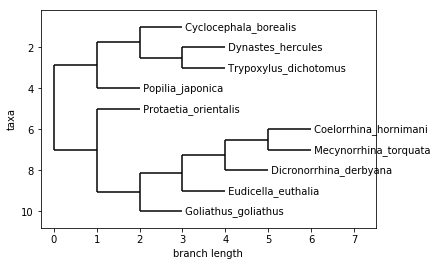

In [11]:
Phylo.draw(tree)

In [12]:
species = df.sort_values('mass (g)')['species_underscore'].unique()

cov = np.zeros(shape=(len(species), len(species)))
comp_matrix = np.zeros(shape=(len(species), len(species))).astype(str)

for i, spec in enumerate(species):
    for j, comp in enumerate(species):
        if i == j:
            cov[i, j] = 6.0
            continue
        cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
        
        comp_matrix[i, j] = spec + ':' + comp

In [13]:
cov

array([[6., 1., 0., 0., 0., 0., 2., 0., 0., 2.],
       [1., 6., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 6., 1., 1., 1., 0., 1., 1., 0.],
       [0., 0., 1., 6., 3., 4., 0., 5., 2., 0.],
       [0., 0., 1., 3., 6., 3., 0., 3., 2., 0.],
       [0., 0., 1., 4., 3., 6., 0., 4., 2., 0.],
       [2., 1., 0., 0., 0., 0., 6., 0., 0., 3.],
       [0., 0., 1., 5., 3., 4., 0., 6., 2., 0.],
       [0., 0., 1., 2., 2., 2., 0., 2., 6., 0.],
       [2., 1., 0., 0., 0., 0., 3., 0., 0., 6.]])

In [14]:
print(pd.DataFrame(cov))
pd.DataFrame(comp_matrix)

     0    1    2    3    4    5    6    7    8    9
0  6.0  1.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  2.0
1  1.0  6.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0
2  0.0  0.0  6.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0
3  0.0  0.0  1.0  6.0  3.0  4.0  0.0  5.0  2.0  0.0
4  0.0  0.0  1.0  3.0  6.0  3.0  0.0  3.0  2.0  0.0
5  0.0  0.0  1.0  4.0  3.0  6.0  0.0  4.0  2.0  0.0
6  2.0  1.0  0.0  0.0  0.0  0.0  6.0  0.0  0.0  3.0
7  0.0  0.0  1.0  5.0  3.0  4.0  0.0  6.0  2.0  0.0
8  0.0  0.0  1.0  2.0  2.0  2.0  0.0  2.0  6.0  0.0
9  2.0  1.0  0.0  0.0  0.0  0.0  3.0  0.0  0.0  6.0


0                                 1  \
0                               0.0  Cyclocephala_borealis:Popilia_ja   
1  Popilia_japonica:Cyclocephala_bo                               0.0   
2  Protaetia_orientalis:Cyclocephal  Protaetia_orientalis:Popilia_jap   
3  Coelorrhina_hornimani:Cyclocepha  Coelorrhina_hornimani:Popilia_ja   
4  Eudicella_euthalia:Cyclocephala_  Eudicella_euthalia:Popilia_japon   
5  Dicronorrhina_derbyana:Cycloceph  Dicronorrhina_derbyana:Popilia_j   
6  Trypoxylus_dichotomus:Cyclocepha  Trypoxylus_dichotomus:Popilia_ja   
7  Mecynorrhina_torquata:Cyclocepha  Mecynorrhina_torquata:Popilia_ja   
8  Goliathus_goliathus:Cyclocephala  Goliathus_goliathus:Popilia_japo   
9  Dynastes_hercules:Cyclocephala_b  Dynastes_hercules:Popilia_japoni   

                                  2                                 3  \
0  Cyclocephala_borealis:Protaetia_  Cyclocephala_borealis:Coelorrhin   
1  Popilia_japonica:Protaetia_orien  Popilia_japonica:Coelorrhina_hor   
2                               0.0  Protaetia_orientalis:Coelorrhina   
3  Coelorrhina_hornimani:Protaetia_                               0.0   
4  Eudicella_euthalia:Protaetia_ori  Eudicella_euthalia:Coelorrhina_h   
5  Dicronorrhina_derbyana:Protaetia  Dicronorrhina_derbyana:Coelorrhi   
6  Trypoxylus_dichotomus:Protaetia_  Trypoxylus_dichotomus:Coelorrhin   
7  Mecynorrhina_torquata:Protaetia_  Mecynorrhina_torquata:Coelorrhin   
8  Goliathus_goliathus:Protaetia_or  Goliathus_goliathus:Coelorrhina_   
9  Dynastes_hercules:Protaetia_orie  Dynastes_hercules:Coelorrhina_ho   

                                  4                                 5  \
0  Cyclocephala_borealis:Eudicella_  Cyclocephala_borealis:Dicronorrh   
1  Popilia_japonica:Eudicella_eutha  Popilia_japonica:Dicronorrhina_d   
2  Protaetia_orientalis:Eudicella_e  Protaetia_orientalis:Dicronorrhi   
3  Coelorrhina_hornimani:Eudicella_  Coelorrhina_hornimani:Dicronorrh   
4                               0.0  Eudicella_euthalia:Dicronorrhina   
5  Dicronorrhina_derbyana:Eudicella                               0.0   
6  Trypoxylus_dichotomus:Eudicella_  Trypoxylus_dichotomus:Dicronorrh   
7  Mecynorrhina_torquata:Eudicella_  Mecynorrhina_torquata:Dicronorrh   
8  Goliathus_goliathus:Eudicella_eu  Goliathus_goliathus:Dicronorrhin   
9  Dynastes_hercules:Eudicella_euth  Dynastes_hercules:Dicronorrhina_   

                                  6                                 7  \
0  Cyclocephala_borealis:Trypoxylus  Cyclocephala_borealis:Mecynorrhi   
1  Popilia_japonica:Trypoxylus_dich  Popilia_japonica:Mecynorrhina_to   
2  Protaetia_orientalis:Trypoxylus_  Protaetia_orientalis:Mecynorrhin   
3  Coelorrhina_hornimani:Trypoxylus  Coelorrhina_hornimani:Mecynorrhi   
4  Eudicella_euthalia:Trypoxylus_di  Eudicella_euthalia:Mecynorrhina_   
5  Dicronorrhina_derbyana:Trypoxylu  Dicronorrhina_derbyana:Mecynorrh   
6                               0.0  Trypoxylus_dichotomus:Mecynorrhi   
7  Mecynorrhina_torquata:Trypoxylus                               0.0   
8  Goliathus_goliathus:Trypoxylus_d  Goliathus_goliathus:Mecynorrhina   
9  Dynastes_hercules:Trypoxylus_dic  Dynastes_hercules:Mecynorrhina_t   

                                  8                                 9  
0  Cyclocephala_borealis:Goliathus_  Cyclocephala_borealis:Dynastes_h  
1  Popilia_japonica:Goliathus_golia  Popilia_japonica:Dynastes_hercul  
2  Protaetia_orientalis:Goliathus_g  Protaetia_orientalis:Dynastes_he  
3  Coelorrhina_hornimani:Goliathus_  Coelorrhina_hornimani:Dynastes_h  
4  Eudicella_euthalia:Goliathus_gol  Eudicella_euthalia:Dynastes_herc  
5  Dicronorrhina_derbyana:Goliathus  Dicronorrhina_derbyana:Dynastes_  
6  Trypoxylus_dichotomus:Goliathus_  Trypoxylus_dichotomus:Dynastes_h  
7  Mecynorrhina_torquata:Goliathus_  Mecynorrhina_torquata:Dynastes_h  
8                               0.0  Goliathus_goliathus:Dynastes_her  
9  Dynastes_hercules:Goliathus_goli                               0.0

In [15]:
df_averages.loc[df_averages['spiracle'] == '1']

species      species_underscore spiracle  area (mm^2)  \
0    Coelorrhina hornimani   Coelorrhina_hornimani        1     0.135347   
8   Dicronorrhina derbyana  Dicronorrhina_derbyana        1     0.084961   
16      Eudicella euthalia      Eudicella_euthalia        1     0.095081   
24     Goliathus goliathus     Goliathus_goliathus        1     1.247407   
32   Mecynorrhina torquata   Mecynorrhina_torquata        1     0.425596   
40    Protaetia orientalis    Protaetia_orientalis        1     0.099677   
48   Cyclocephala borealis   Cyclocephala_borealis        1     0.026488   
56       Dynastes hercules       Dynastes_hercules        1     0.752373   
64   Trypoxylus dichotomus   Trypoxylus_dichotomus        1     0.115794   
72        Popilia japonica        Popilia_japonica        1     0.007094   

    depth (mm)  mass (g)   subfamily  subfam_count  log area (mm^2)  log dist  \
0     0.416717    1.1300  Cetoniinae             6        -0.868551 -0.380159   
8     0.510178    2.1325  Cetoniinae             6        -1.070783 -0.292278   
16    0.524408    2.1835  Cetoniinae             6        -1.021908 -0.280330   
24    1.281943   17.2150  Cetoniinae             6         0.096008  0.107869   
32    0.985361    6.9510  Cetoniinae             6        -0.371003 -0.006405   
40    0.204920    1.3750  Cetoniinae             6        -1.001407 -0.688415   
48    0.203491    0.1077  Dynastinae             3        -1.576955 -0.691454   
56    0.917219   26.3500  Dynastinae             3        -0.123567 -0.037527   
64    0.550296    6.4149  Dynastinae             3        -0.936314 -0.259403   
72    0.224798    0.1312   Rutelinae             1        -2.149139 -0.648208   

    log mass (g)  log area/dist  log area^2/dist  
0       0.053078      -0.488392        -1.356943  
8       0.328889      -0.778505        -1.849287  
16      0.339153      -0.741578        -1.763486  
24      1.235907      -0.011860         0.084148  
32      0.842047      -0.364598        -0.735601  
40      0.138303      -0.312992        -1.314399  
48     -0.967784      -0.885501        -2.462456  
56      1.420781      -0.086040        -0.209606  
64      0.807190      -0.676911        -1.613225  
72     -0.882066      -1.500931        -3.650070

With our data in this format, we can build the PGLS model for our regression. To do this, we will write a statistical model for the data. We choose a multivariate normal distribution with covariance matrix given by the above matrix adjusted by the parameter $\lambda$ (as in PGLS), and put a prior on $\lambda$. This gives

\begin{align}
f(x_i; a, b) &= ax_i + b \\
b &\sim \text{Norm}(0, 1) \\
a &\sim \text{Norm}(0, 2) \\
\lambda &\sim \text{beta}(1.1, 1.1) \\
y_i &\sim \text{multi_normal}\left(f_\mu(x_i; a, b), f_\sigma(\mathrm{cov}, \lambda)\right)
\end{align}


Time for a prior predictive check on our model!

In [16]:
sm_prior_pred = cmdstanpy.CmdStanModel(
    stan_file="spiracle_pgls_prior_predictive.stan"
)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagner2/git/spiracle_scaling/spiracle_pgls_prior_predictive.exe


In [17]:
x = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == '1', 'log mass (g)'].values

data = {
    "N": len(x),
    "x": x,
    "a_mu": 0.66,
    "a_sig": 0.3,
    "b_mu": -1.0,
    "b_sig": 1.0,
    "lambda_alpha": 1.1,
    "lambda_beta": 1.1,
    "cov_phylo":cov,
}

samples = sm_prior_pred.sample(data=data, sampling_iters=1000, fixed_param=True)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [18]:
samples = az.from_cmdstanpy(posterior=samples, prior=samples, prior_predictive=['y'])

In [19]:
bokeh.io.show(
    
    bebi103.viz.predictive_regression(
        samples.prior_predictive['y'],
        samples_x=x,
        percentiles=[30, 60, 90, 99],
        x_axis_label='mass',
        y_axis_label='area',
    )
)

In [20]:
p = bokeh.plotting.figure()
p.circle('log mass (g)', 'log area (mm^2)', source=df_averages.loc[df_averages['spiracle'] == '1'])
bokeh.io.show(p)

In [21]:
size = 1000
lines = [a*x+b+sample for a, b, sample in zip(np.random.normal(0,2, size=size), np.random.normal(0,1,size=size),
                                              np.random.multivariate_normal(x, cov, size=size))]#+np.random.normal(0, 3, size=(100,) ))]

In [22]:
p = bokeh.plotting.figure()
[p.line(x, y, alpha=0.2) for y in lines]
bokeh.io.show(p)

In [23]:
species = df.sort_values('mass (g)')['species_underscore'].unique()

cov = np.zeros(shape=(len(species), len(species)))
comp_matrix = np.zeros(shape=(len(species), len(species))).astype(str)

for i, spec in enumerate(species):
    for j, comp in enumerate(species):
        #if i == j:
        #    cov[i, j] = 6.0
        #    continue
        cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
        
        comp_matrix[i, j] = spec + ':' + comp

In [24]:
size = 1000
lines = [a*x+b+sample for a, b, sample in zip(np.random.normal(0,2, size=size), np.random.normal(0,1,size=size),
                                              np.random.multivariate_normal(x, cov, size=size))]#+np.random.normal(0, 3, size=(100,) ))]

In [25]:
p = bokeh.plotting.figure()
[p.line(x, y, alpha=0.2) for y in lines]
bokeh.io.show(p)

In [26]:
cov

array([[3., 1., 0., 0., 0., 0., 2., 0., 0., 2.],
       [1., 2., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 2., 1., 1., 1., 0., 1., 1., 0.],
       [0., 0., 1., 6., 3., 4., 0., 5., 2., 0.],
       [0., 0., 1., 3., 4., 3., 0., 3., 2., 0.],
       [0., 0., 1., 4., 3., 5., 0., 4., 2., 0.],
       [2., 1., 0., 0., 0., 0., 4., 0., 0., 3.],
       [0., 0., 1., 5., 3., 4., 0., 6., 2., 0.],
       [0., 0., 1., 2., 2., 2., 0., 2., 3., 0.],
       [2., 1., 0., 0., 0., 0., 3., 0., 0., 4.]])

In [27]:
plots = []
sample = np.random.multivariate_normal(x, cov, size=1000)
num = df_averages.sort_values('mass (g)').loc[df_averages.sort_values('mass (g)')['spiracle']=='1', 'subfam_count'].values
for i in range(len(sample[0])):
    for j in range(len(sample[0]))[i:-1]:
        p = bokeh.plotting.figure(plot_width=200, plot_height=200, x_range=(-5, 5), y_range=(-5, 5), title='comp of ' +str(i)+' and '+str(j)+' | '+str(num[i])+','+str(num[j]))
        p.circle(sample[:, i], sample[:, j], alpha=0.1)
        plots.append(p)

In [28]:
bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=4))

In [29]:
p = bokeh.plotting.figure()
[p.circle(x, sample, alpha=0.05) for sample in np.random.multivariate_normal(x, cov, size=1000)]
bokeh.io.show(p)

In [30]:
print(df_averages.sort_values('mass (g)').loc[df_averages.sort_values('mass (g)')['spiracle']=='1', 'subfam_count'].values)

[3 1 6 6 6 6 3 6 6 3]


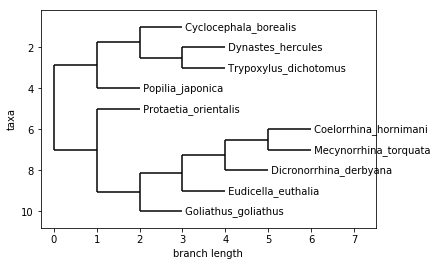

In [31]:
Phylo.draw(tree)

In [32]:
species = df.sort_values('mass (g)')['species_underscore'].unique()

cov = np.zeros(shape=(len(species), len(species)))
comp_matrix = np.zeros(shape=(len(species), len(species))).astype(str)

for i, spec in enumerate(species):
    for j, comp in enumerate(species):
        if i == j:
            cov[i, j] = 6.0
            continue
        cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
        
        comp_matrix[i, j] = spec + ':' + comp

In [33]:
cov*1/1000

array([[0.006, 0.001, 0.   , 0.   , 0.   , 0.   , 0.002, 0.   , 0.   ,
        0.002],
       [0.001, 0.006, 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.   ,
        0.001],
       [0.   , 0.   , 0.006, 0.001, 0.001, 0.001, 0.   , 0.001, 0.001,
        0.   ],
       [0.   , 0.   , 0.001, 0.006, 0.003, 0.004, 0.   , 0.005, 0.002,
        0.   ],
       [0.   , 0.   , 0.001, 0.003, 0.006, 0.003, 0.   , 0.003, 0.002,
        0.   ],
       [0.   , 0.   , 0.001, 0.004, 0.003, 0.006, 0.   , 0.004, 0.002,
        0.   ],
       [0.002, 0.001, 0.   , 0.   , 0.   , 0.   , 0.006, 0.   , 0.   ,
        0.003],
       [0.   , 0.   , 0.001, 0.005, 0.003, 0.004, 0.   , 0.006, 0.002,
        0.   ],
       [0.   , 0.   , 0.001, 0.002, 0.002, 0.002, 0.   , 0.002, 0.006,
        0.   ],
       [0.002, 0.001, 0.   , 0.   , 0.   , 0.   , 0.003, 0.   , 0.   ,
        0.006]])

In [68]:
x = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == 'S', 'log mass (g)'].values
y = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == 'S', 'log area/dist'].values

data = {
    "N": len(x),
    "x": x,
    "y": y,
    "cov_phylo":cov,
}


In [80]:
sm = cmdstanpy.CmdStanModel(stan_file='spiracle_pgls_model.stan')

samples = sm.sample(data=data, sampling_iters=1000, chains=4)

samples = az.from_cmdstanpy(posterior=samples, posterior_predictive=["y_ppc"])

INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: C:/Users/jwagner2/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


In [81]:
bebi103.stan.check_all_diagnostics(samples, var_names=['b', 'a'])

Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


0

In [83]:
bokeh.io.show(
    bebi103.viz.corner(
        samples, pars=["a", "b", "lambda", "sigma"], xtick_label_orientation=np.pi / 4
    )
)

In [84]:
p = bokeh.plotting.figure()
norm = np.linspace(-1, 1.5, 200)

bebi103.viz.ecdf(samples.posterior['a'].values.ravel(), color='red', p=p)

p.line(norm, scipy.stats.norm.cdf(norm, 0.33, 0.3))

bokeh.io.show(p)

In [85]:
az.summary(samples, var_names=['b', 'a', 'lambda'])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
b      -0.135  0.066  -0.256   -0.006      0.001    0.001    2049.0  2049.0   
a       0.460  0.119   0.230    0.676      0.003    0.002    2076.0  2076.0   
lambda  0.493  0.254   0.051    0.931      0.005    0.003    3093.0  2956.0   

        ess_bulk  ess_tail  r_hat  
b         2081.0    2270.0    1.0  
a         2114.0    2170.0    1.0  
lambda    2940.0    2276.0    1.0

In [86]:
az.summary(samples, var_names=['b', 'a'])['mean']['a'] + az.summary(samples, var_names=['b', 'a'])['sd']['a']*1.96

0.69324

In [87]:
az.summary(samples, var_names=['b', 'a'])['mean']['a'] - az.summary(samples, var_names=['b', 'a'])['sd']['a']*1.96

0.22676000000000004

In [88]:
bokeh.io.show(bebi103.viz.ecdf(samples.posterior['a'].values.ravel()-0.333))

In [89]:
np.sum(samples.posterior['a'].values.ravel()-0.333 < 0)/len(samples.posterior['a'].values.ravel())

0.13925

In [91]:
y_ppc = samples.posterior_predictive['y_ppc'].stack(
    {"sample": ("chain", "draw")}
).transpose("sample", "y_ppc_dim_0")

bokeh.io.show(
    bebi103.viz.predictive_regression(
        y_ppc,
        samples_x=x,
        percentiles=[30, 50, 70, 95],
        data=np.vstack((x, y)).transpose(),
        x_axis_label='ant density, k [ant/cm^2]',
        y_axis_label='ant flow, q [ant/cm/s]',
        x_range=[x.min()-0.1, x.max()+0.1],
    )
)

In [92]:
p = bokeh.plotting.figure(x_axis_label='log mass', y_axis_label='log area')

Y = df.sort_values('mass (g)').loc[df['spiracle'] == '2', 'log area/dist'].values
X = df.sort_values('mass (g)').loc[df['spiracle'] == '2', 'log mass (g)'].values
X = statsmodels.api.add_constant(X)
model = statsmodels.api.OLS(Y,X)
results = model.fit()
results.params


p.circle(df.sort_values('mass (g)').loc[df['spiracle'] == '2', 'log mass (g)'].values,
         df.sort_values('mass (g)').loc[df['spiracle'] == '2', 'log area/dist'].values, color='black', size=15, alpha=0.3, fill_color='green')

p.line(np.linspace(x.min(), x.max(), 200),
       results.params[1]*np.linspace(x.min(), x.max(), 200) + results.params[0],
       line_width=5, line_dash='dashed', color='orange', alpha=0.3)


Y = y
X = x
X = statsmodels.api.add_constant(X)
model = statsmodels.api.OLS(Y,X)
results = model.fit()
results.params

p.line(np.linspace(x.min(), x.max(), 200),
       az.summary(samples, var_names=['b', 'a'])['mean']['a']*np.linspace(x.min(), x.max(), 200) + az.summary(samples, var_names=['b', 'a'])['mean']['b'],
       line_width=5, color='black')

p.line(np.linspace(x.min(), x.max(), 200),
       results.params[1]*np.linspace(x.min(), x.max(), 200) + results.params[0],
       line_width=5, line_dash='dashed', color='grey')

p.circle(x, y, color='black', size=15, alpha=0.5, fill_color='red')



bokeh.io.show(p)

In [46]:
p = bokeh.plotting.figure(x_axis_label='log mass', y_axis_label='log area')

p.circle(df.sort_values('mass (g)').loc[df['spiracle'] == '1', 'log mass (g)'].values,
         df.sort_values('mass (g)').loc[df['spiracle'] == '1', 'log area (mm^2)'].values, color='black', size=15, alpha=0.8, fill_color='red')

bokeh.io.show(p)

In [47]:
species = df.sort_values('mass (g)')['species_underscore'].unique()

cov = np.zeros(shape=(len(species), len(species)))
comp_matrix = np.zeros(shape=(len(species), len(species))).astype(str)

for i, spec in enumerate(species):
    for j, comp in enumerate(species):
        
        comp_matrix[i, j] = spec + ':' + comp
        
        if i == j:
            cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
            continue
            
        cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
        
        
cov

array([[3., 1., 0., 0., 0., 0., 2., 0., 0., 2.],
       [1., 2., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 2., 1., 1., 1., 0., 1., 1., 0.],
       [0., 0., 1., 6., 3., 4., 0., 5., 2., 0.],
       [0., 0., 1., 3., 4., 3., 0., 3., 2., 0.],
       [0., 0., 1., 4., 3., 5., 0., 4., 2., 0.],
       [2., 1., 0., 0., 0., 0., 4., 0., 0., 3.],
       [0., 0., 1., 5., 3., 4., 0., 6., 2., 0.],
       [0., 0., 1., 2., 2., 2., 0., 2., 3., 0.],
       [2., 1., 0., 0., 0., 0., 3., 0., 0., 4.]])

In [48]:
cov=np.linalg.inv(cov)
print(pd.DataFrame(np.round(cov, decimals=3)))

       0      1      2      3      4      5      6      7      8      9
0  0.571 -0.143  0.000  0.000  0.000  0.000 -0.143  0.000  0.000 -0.143
1 -0.143  0.619  0.000  0.000  0.000  0.000 -0.048  0.000  0.000 -0.048
2  0.000  0.000  0.618 -0.007 -0.056 -0.021  0.000 -0.007 -0.146  0.000
3  0.000  0.000 -0.007  0.618 -0.056 -0.146  0.000 -0.382 -0.021  0.000
4  0.000  0.000 -0.056 -0.056  0.556 -0.167  0.000 -0.056 -0.167  0.000
5  0.000  0.000 -0.021 -0.146 -0.167  0.562  0.000 -0.146 -0.062  0.000
6 -0.143 -0.048  0.000  0.000  0.000  0.000  0.619  0.000  0.000 -0.381
7  0.000  0.000 -0.007 -0.382 -0.056 -0.146  0.000  0.618 -0.021  0.000
8  0.000  0.000 -0.146 -0.021 -0.167 -0.062  0.000 -0.021  0.562  0.000
9 -0.143 -0.048  0.000  0.000  0.000  0.000 -0.381  0.000  0.000  0.619


In [49]:
x = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == '3', 'log mass (g)'].values
y = df_averages.sort_values('mass (g)').loc[df_averages['spiracle'] == '3', 'log area (mm^2)'].values

data = {
    "N": len(x),
    "x": x,
    "y": y,
    "cov_phylo":cov,
}


In [50]:
sm = cmdstanpy.CmdStanModel(stan_file='spiracle_pgls_model.stan')

samples = sm.sample(data=data, sampling_iters=1000, chains=4)

samples = az.from_cmdstanpy(posterior=samples, posterior_predictive=["y_ppc"])

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: C:/Users/jwagner2/git/spiracle_scaling/spiracle_pgls_model.exe
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


In [51]:
bebi103.stan.check_all_diagnostics(samples, var_names=['b', 'a', 'lambda'])

Effective sample size looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


0

In [52]:
bokeh.io.show(
    bebi103.viz.corner(
        samples, pars=["a", "b", "lambda"], xtick_label_orientation=np.pi / 4
    )
)

In [53]:
y_ppc = samples.posterior_predictive['y_ppc'].stack(
    {"sample": ("chain", "draw")}
).transpose("sample", "y_ppc_dim_0")

bokeh.io.show(
    bebi103.viz.predictive_regression(
        y_ppc,
        samples_x=x,
        percentiles=[30, 50, 70, 99],
        data=np.vstack((x, y)).transpose(),
        x_axis_label='ant density, k [ant/cm^2]',
        y_axis_label='ant flow, q [ant/cm/s]',
        x_range=[x.min()-0.1, x.max()+0.1],
    )
)

In [54]:
p = bokeh.plotting.figure()
p.line(np.linspace(-1, 1.5, 200), np.linspace(-1, 1.5, 200)*0.7672-1.4551)
p.line(np.linspace(-1, 1.5, 200), np.linspace(-1, 1.5, 200)*0.5887-1.3282, color='red')
p.line(np.linspace(-1, 1.5, 200), np.linspace(-1, 1.5, 200)*az.summary(samples, var_names=['b', 'a', 'lambda'])['mean'][1]
       + az.summary(samples, var_names=['b', 'a', 'lambda'])['mean'][0], color='black')
p.circle(x, y, size=15)
bokeh.io.show(p)

In [55]:
az.summary(samples, var_names=['b', 'a', 'lambda'])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
b      -1.273  0.125  -1.518   -1.037      0.003    0.002    1933.0  1909.0   
a       0.456  0.211   0.044    0.841      0.005    0.003    1884.0  1867.0   
lambda  0.952  0.063   0.841    1.000      0.001    0.001    3216.0  3095.0   

        ess_bulk  ess_tail  r_hat  
b         1949.0    1809.0    1.0  
a         1882.0    1964.0    1.0  
lambda    1601.0    1277.0    1.0

In [56]:
library(nlme)
cat("((((Homo:0.21,Pongo:0.21):0.28,",
"Macaca:0.49):0.13,Ateles:0.62):0.38,Galago:1.00);",
file = "ex.tre", sep = "\n")
tree.primates <- read.tree("ex.tre")
X <- c(4.09434, 3.61092, 2.37024, 2.02815, -1.46968)
Y <- c(4.74493, 3.33220, 3.36730, 2.89037, 2.30259)
unlink("ex.tre") # delete the file "ex.tre"
m1 <- gls(Y ~ X, correlation=corBrownian(1, tree.primates))
corMatrix(m1$modelStruct$corStruct)
summary(m1)
m2 <- gls(Y ~ X, correlation=corMartins(1, tree.primates))
summary(m2)
corMatrix(m2$modelStruct$corStruct)
m3 <- gls(Y ~ X, correlation=corGrafen(1, tree.primates))
summary(m3)
corMatrix(m3$modelStruct$corStruct)

SyntaxError: invalid syntax (<ipython-input-56-8452e6f8c646>, line 9)

In [ ]:
tree = Phylo.read(io.StringIO("((((Homo:0.21,Pongo:0.21):0.28,Macaca:0.49):0.13,Ateles:0.62):0.38,Galago:1.00);"),
          "newick")

In [ ]:
Phylo.draw(tree)

In [ ]:
species = ["Homo","Pongo","Macaca","Ateles","Galago"]

cov = np.zeros(shape=(len(species), len(species)))
comp_matrix = np.zeros(shape=(len(species), len(species))).astype(str)

for i, spec in enumerate(species):
    for j, comp in enumerate(species):
        
        comp_matrix[i, j] = spec + ':' + comp
        
        if i == j:
            cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
            continue
            
        cov[i, j] = tree.depths()[tree.common_ancestor(spec, comp)]
        
        
pd.DataFrame(cov,index=species, columns=species)

In [ ]:
X = np.array((4.09434, 3.61092, 2.37024, 2.02815, -1.46968))
Y = np.array((4.74493, 3.33220, 3.36730, 2.89037, 2.30259))

In [ ]:
p = bokeh.plotting.figure()
p.circle(X, Y)

bokeh.io.show(p)

In [ ]:
data = {
    "N": len(X),
    "x": X,
    "y": Y,
    "cov_phylo":cov,
}

sm = cmdstanpy.CmdStanModel(stan_file='spiracle_pgls_model.stan')

samples = sm.sample(data=data, sampling_iters=1000, chains=4)

samples = az.from_cmdstanpy(posterior=samples, posterior_predictive=["y_ppc"])

In [ ]:
bebi103.stan.check_all_diagnostics(samples, var_names=['b', 'a'])

In [ ]:
bokeh.io.show(
    bebi103.viz.corner(
        samples, pars=["a", "b"], xtick_label_orientation=np.pi / 4
    )
)

In [ ]:
az.summary(samples, ['a', 'b'])

In [ ]:
np.std(np.array(samples.posterior['a']))

In [ ]:
0.7754516*np.sqrt(5)

In [ ]:
y_ppc = samples.posterior_predictive['y_ppc'].stack(
    {"sample": ("chain", "draw")}
).transpose("sample", "y_ppc_dim_0")

bokeh.io.show(
    bebi103.viz.predictive_regression(
        y_ppc,
        samples_x=X,
        percentiles=[30, 50, 70, 99],
        data=np.vstack((X, Y)).transpose(),
        x_axis_label='ant density, k [ant/cm^2]',
        y_axis_label='ant flow, q [ant/cm/s]',
        x_range=[X.min()-0.1,X.max()+0.1],
    )
)

In [ ]:
bebi103.stan.clean_cmdstan()

In [ ]:
cov=[[3.0, 2.0, 1.0, 1.0, 0.0],
     [2.0, 3.0, 1.0, 1.0, 0.0],
     [1.0, 1.0, 3.0, 2.0, 0.0],
     [1.0, 1.0, 2.0, 3.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 3.0]]

In [ ]:
cov=np.array([[3.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 3.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 3.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 3.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 3.0]])*1/10

In [ ]:
x=np.array([1.02, 1.06, 0.96, 0.92, 0.89])
y=np.array([1.38, 1.41, 1.36, 1.22, 1.13])

In [ ]:
p = bokeh.plotting.figure()
p.circle(x, y)

bokeh.io.show(p)

In [ ]:
data = {
    "N": len(x),
    "x": x,
    "y": y,
    "cov_phylo":cov,
}

sm = cmdstanpy.CmdStanModel(stan_file='spiracle_pgls_model.stan')

samples = sm.sample(data=data, sampling_iters=1000, chains=4, adapt_delta=0.99)

samples = az.from_cmdstanpy(posterior=samples, posterior_predictive=["y_ppc"])

In [ ]:
bebi103.stan.check_all_diagnostics(samples, var_names=['b', 'a', 'lambda'])

In [ ]:
bokeh.io.show(
    bebi103.viz.corner(
        samples, pars=["a", "b", "lambda"], xtick_label_orientation=np.pi / 4
    )
)

In [ ]:
az.summary(samples, ['a', 'b', 'lambda'])

In [ ]:
y_ppc = samples.posterior_predictive['y_ppc'].stack(
    {"sample": ("chain", "draw")}
).transpose("sample", "y_ppc_dim_0")

bokeh.io.show(
    bebi103.viz.predictive_regression(
        y_ppc,
        samples_x=x,
        percentiles=[30, 50, 70, 99],
        data=np.vstack((x, y)).transpose(),
        x_axis_label='ant density, k [ant/cm^2]',
        y_axis_label='ant flow, q [ant/cm/s]',
        x_range=[x.min()-0.1,x.max()+0.1],
    )
)